# Análise de dados: Falsificação de cédulas de Real (R$)

Neste projeto serão analisados os dados de falsificação de cédulas de Real (R$) com base nos dados informações (.csv) do período entre 1995 e 2020 acessíveis no portal de [Dados Abertos](https://dadosabertos.bcb.gov.br/) disponibilizados pelo [Banco Central do Brasil](https://www.bcb.gov.br/).

## Demanda da análise

- Demonstrar a evolução das falsificações
- Identificar as cédulas mais falsificadas
- Identificar os estados com mais incidência de falsificações
- Estimar para os próximos anos a incidência de falsificações

## Indagações a serem respondidas pela análise exploratória dos dados

1. Qual o total de falsificações por cédula (1995 a 2020)?
2. Qual o total de falsificações por ano (1995 a 2020)?
3. Qual o total de falsificações por cédula e por ano (1995 a 2020)?
4. Qual o total de falsificações por estado no período de 1995 a 2020?
5. Qual a estimativa do total de falsificações por ano (2021 e 2022)?
6. Qual a estimativa do total de falsificações por cédula e por ano (2021 e 2022)?
7. Qual a estimativa do total de falsificações por estado no período de 2021 e 2022?

## Importação de pacotes

In [2]:
# Importação de pacotes e definição de parâmetros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
import statsmodels.api as sm
import warnings
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Carregamento dos dados

In [3]:
# Criando um dataframe atribuindo o arquivo csv no diretório dados e definindo o nome das colunas

df = pd.read_csv('dados/Falsificacao_DadosAbertos.csv', sep=';', header=None)

df.columns = ['Ano', 'Estado', 'Família', 'Denominação', 'Quantidade']


## Detalhes do dataframe

In [4]:
# Amostra de dados do dataframe

df.sample(10)

,Ano,Estado,Família,Denominação,Quantidade
683,2003,AMAPÁ,Cédulas - 1a. família,50.0,"130,00"
5539,2021,RIO DE JANEIRO,Cédulas - 1a. família,2.0,"8,00"
4764,2019,DISTRITO FEDERAL,Cédulas - 2a. família,20.0,"2.198,00"
5552,2021,RIO GRANDE DO NORTE,Cédulas - 2a. família,2.0,"2,00"
1758,2008,MATO GROSSO DO SUL,Cédulas - 1a. família,2.0,"7,00"
376,2001,GOIÁS,Cédulas - 1a. família,50.0,"3.594,00"
1687,2008,ALAGOAS,Cédulas - 1a. família,5.0,"127,00"
1801,2008,PARANÁ,Cédulas - 1a. família,50.0,"24.208,00"
1978,2009,NAO INFORMADO,Cédulas - 1a. família,20.0,"1,00"
1993,2009,PARAÍBA,Cédulas - 1a. família,20.0,"305,00"


In [5]:
# Quantidade de linhas e colunas

df.shape

(5680, 5)

In [6]:
# Removendo a coluna que não será utilizada na análise

df = df.drop(columns=['Família'])
df.shape

(5680, 4)

In [7]:
# Informações das colunas como nome, contagem de linhas nulas e tipo de dados

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ano          5680 non-null   int64  
 1   Estado       5680 non-null   object 
 2   Denominação  5680 non-null   float64
 3   Quantidade   5680 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 177.6+ KB


## Tratando valores nulos

In [8]:
# Identificando a quantidade de valores nulos, no caso não há dados nulos

df.isnull().sum()

Ano            0
Estado         0
Denominação    0
Quantidade     0
dtype: int64

## Tratando os tipos de valores

In [9]:
# Identificando os tipos de dados das colunas

df.dtypes

Ano              int64
Estado          object
Denominação    float64
Quantidade      object
dtype: object

In [10]:
# Efetuando as conversões necessárias dos tipos de dados e exibindo novamente as informações das colunas

df['Ano'] = df['Ano'].astype('int')
df['Quantidade'] = [(str(i).replace('.', '')) for i in df['Quantidade']]
df['Quantidade'] = [(str(i).replace(',', '.')) for i in df['Quantidade']]
df['Quantidade'] = [float(str(i)) for i in df['Quantidade']]
df['Quantidade'] = df['Quantidade'].astype('int')

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5680 entries, 0 to 5679
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Ano          5680 non-null   int32  
 1   Estado       5680 non-null   object 
 2   Denominação  5680 non-null   float64
 3   Quantidade   5680 non-null   int32  
dtypes: float64(1), int32(2), object(1)
memory usage: 133.2+ KB


In [11]:
# Contagem de linhas do dataframe

df.count()

Ano            5680
Estado         5680
Denominação    5680
Quantidade     5680
dtype: int64

## Selecionando o período entre 1995 e 2020

In [12]:
# Criando um dataframe com todos os períodos, exceto o ano corrente de 2022

print('-'*30, 'Dataframe: df_full', '-'*30)

df_remover = df.loc[df['Ano'] == 2022]

df_full = df.drop(df_remover.index)

print('\n')
print(df_full['Ano'].unique())
print('\n')

# Criando um dataframe com o período entre 1995 e 2020

print('-'*33, 'Dataframe: df', '-'*33)

df_remover = df.loc[
    (df['Ano'] == 2021) |
    (df['Ano'] == 2022)
]

df = df.drop(df_remover.index)

print('\n')
print(df['Ano'].unique())
print('\n')


------------------------------ Dataframe: df_full ------------------------------


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


--------------------------------- Dataframe: df ---------------------------------


[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]




## Amostra de dados do dataframe após tratamento das informações

In [13]:
df.sample(10)

,Ano,Estado,Denominação,Quantidade
5278,2020,RONDÔNIA,50.0,24
1300,2006,BAHIA,5.0,1383
5334,2020,TOCANTINS,50.0,120
951,2004,MINAS GERAIS,2.0,64
1485,2007,ALAGOAS,10.0,605
2693,2012,PIAUÍ,50.0,374
3320,2014,RIO GRANDE DO NORTE,2.0,5
3879,2016,MINAS GERAIS,50.0,7380
165,1999,PIAUÍ,100.0,1
1818,2008,RIO DE JANEIRO,1.0,3


## 1. Qual o total de falsificações por cédula (1995 a 2020)?

             Quantidade          %
Denominação                       
1.0                2419   0.023213
2.0               32297   0.309928
5.0              395642   3.796649
10.0            1682557  16.146108
20.0            1224727  11.752692
50.0            4486479  43.053028
100.0           2592115  24.874384
200.0              4585   0.043998


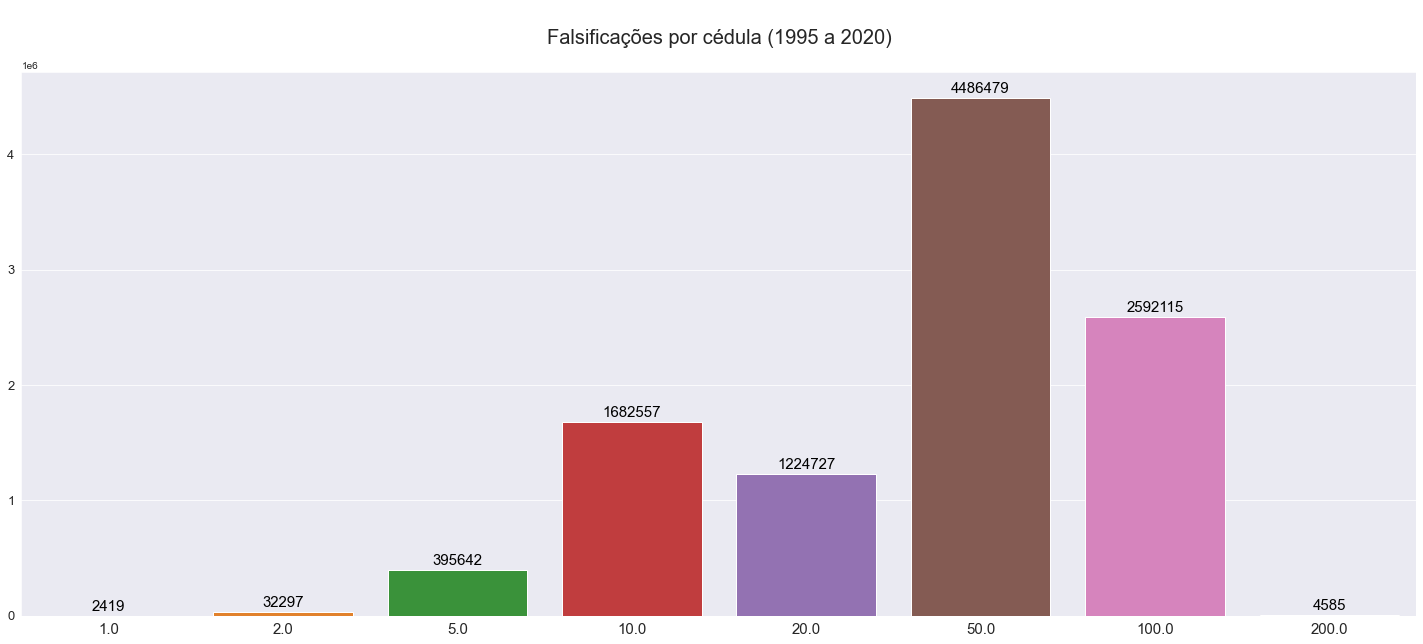

In [14]:
df_temp = df.groupby(['Denominação'])['Quantidade'].sum()
df_denominacao_quantidade = pd.DataFrame(df_temp)
df_denominacao_quantidade['%'] = df_denominacao_quantidade['Quantidade'] / df_denominacao_quantidade['Quantidade'].sum() * 100

print(df_denominacao_quantidade)

plt.figure(figsize=(25, 10))
plot = sns.barplot(x=df_denominacao_quantidade.index,
                   y=df_denominacao_quantidade['Quantidade'],
                   orient='v',
                   palette='tab10')
for i in plot.patches:
    plot.annotate(format(i.get_height(), '.0f'),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center',
                  va='baseline',
                  fontsize=15,
                  color='black',
                  xytext=(0, 5),
                  textcoords='offset points')
plt.xticks(size=15)
plt.yticks(size=13)                  
plt.xlabel('')
plt.ylabel('')
plt.title('\nFalsificações por cédula (1995 a 2020)\n', fontsize=20)
plt.show(plot)

## 2. Qual o total de falsificações por ano (1995 a 2020)?

      Quantidade         %
Ano                       
1995         242  0.002322
1996       16421  0.157579
1997         624  0.005988
1998        6874  0.065964
1999       29162  0.279844
2000      329111  3.158206
2001      381709  3.662946
2002      413883  3.971693
2003      548887  5.267215
2004      499255  4.790937
2005      448158  4.300602
2006      638036  6.122704
2007      678949  6.515312
2008      538201  5.164670
2009      503228  4.829063
2010      434657  4.171044
2011      434084  4.165545
2012      519987  4.989885
2013      551157  5.288998
2014      529578  5.081922
2015      477689  4.583986
2016      506633  4.861738
2017      548542  5.263904
2018      561808  5.391207
2019      498961  4.788116
2020      324985  3.118612


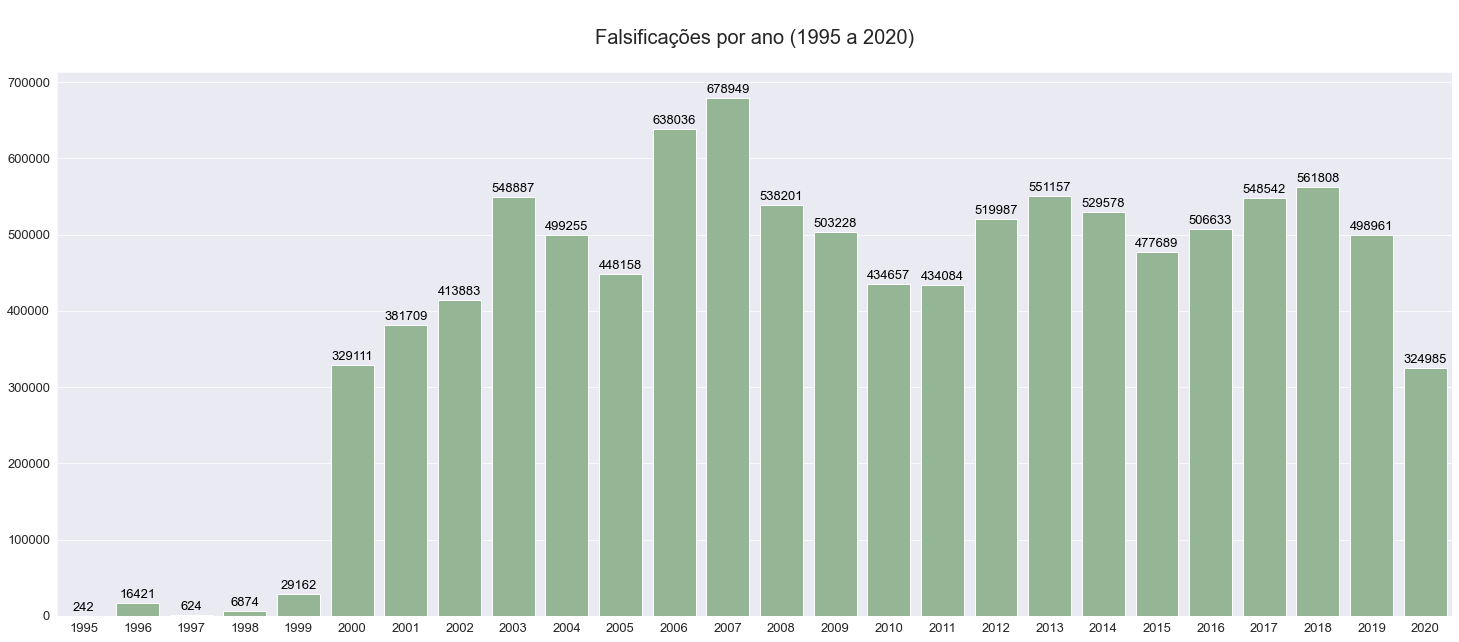

In [15]:
df_temp = df.groupby(['Ano'])['Quantidade'].sum()
df_ano_quantidade = pd.DataFrame(df_temp)
df_ano_quantidade['%'] = df_ano_quantidade['Quantidade'] / df_ano_quantidade['Quantidade'].sum() * 100

print(df_ano_quantidade)

plt.figure(figsize=(25, 10))
plot = sns.barplot(x=df_ano_quantidade.index,
                   y=df_ano_quantidade['Quantidade'],
                   orient='v',
                   palette=['darkseagreen'])
for i in plot.patches:
    plot.annotate(format(i.get_height(), '.0f'),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center',
                  va='baseline',
                  fontsize=13,
                  color='black',
                  xytext=(0, 5),
                  textcoords='offset points')
plt.xticks(size=13)
plt.yticks(size=13)                  
plt.xlabel('')
plt.ylabel('')
plt.title('\nFalsificações por ano (1995 a 2020)\n', fontsize=20)
plt.show(plot)


## 3. Qual o total de falsificações por cédula e por ano (1995 a 2020)?

Ano          1995   1995
Denominação  50.0  100.0
Quantidade    240      2 

Ano         1996  1996  1996   1996
Denominação  5.0  10.0  50.0  100.0
Quantidade     2  6088  8001   2330 

Ano         1997  1997  1997   1997
Denominação  5.0  10.0  50.0  100.0
Quantidade   182   108   154    180 

Ano         1998  1998  1998   1998
Denominação  5.0  10.0  50.0  100.0
Quantidade    72  3512  2181   1109 

Ano         1999 1999   1999   1999   1999
Denominação  1.0  5.0   10.0   50.0  100.0
Quantidade    20  863  12643  14066   1570 

Ano         2000   2000    2000    2000   2000
Denominação  1.0    5.0    10.0    50.0  100.0
Quantidade   294  15914  176003  132244   4656 

Ano         2001   2001    2001  2001    2001   2001
Denominação  1.0    5.0    10.0  20.0    50.0  100.0
Quantidade   336  30340  205249     9  143747   2028 

Ano         2002 2002   2002    2002   2002    2002   2002
Denominação  1.0  2.0    5.0    10.0   20.0    50.0  100.0
Quantidade   405  722  30681  188658  10

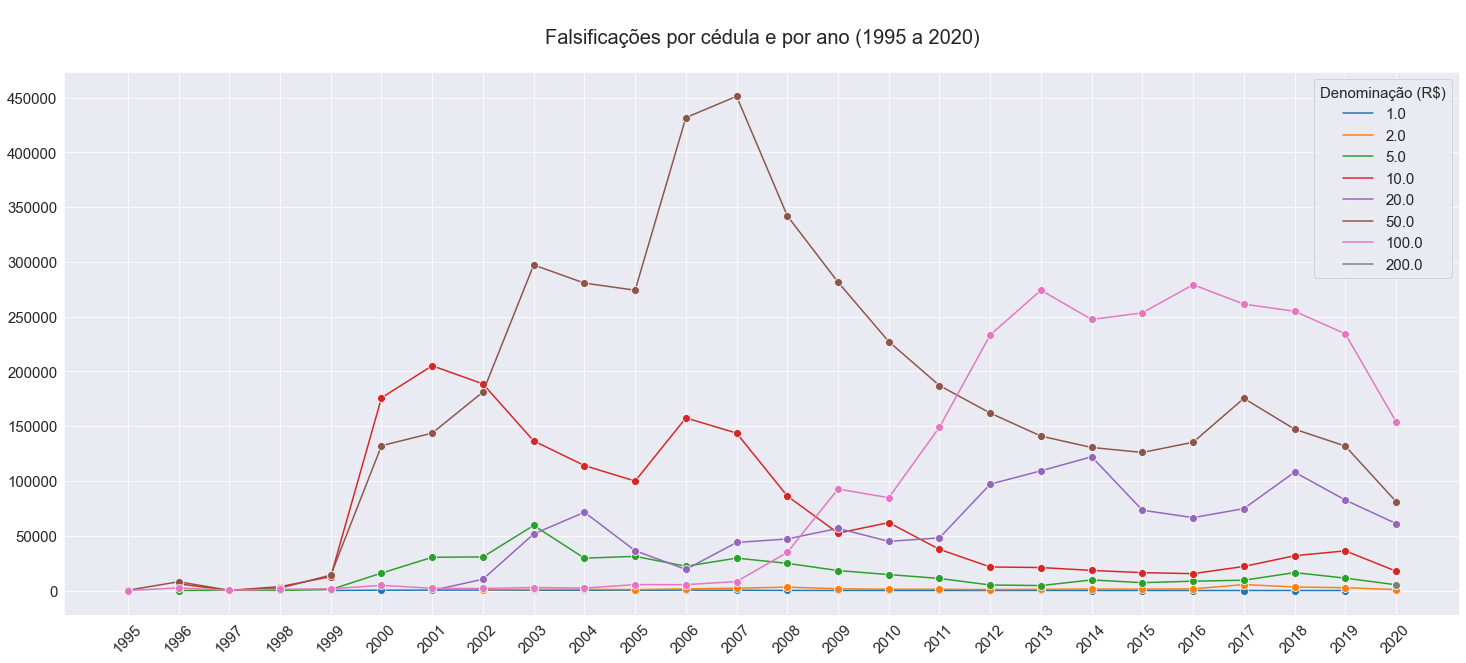

In [16]:
df_temp = df.groupby(['Ano', 'Denominação'])['Quantidade'].sum()
df_ano_denominacao_quantidade = pd.DataFrame(df_temp)

df_ano_denominacao_quantidade.reset_index(level=1, inplace=True, col_level=1)

df_ano_denominacao_quantidade['Denominação'] = df_ano_denominacao_quantidade['Denominação'].astype('str')

tabela = df_ano_denominacao_quantidade.T

for i in set(tabela.columns):
    print(tabela[i], "\n")

plt.figure(figsize=(25, 10))
plot = sns.lineplot(x=df_ano_denominacao_quantidade.index,
                    y=df_ano_denominacao_quantidade['Quantidade'],
                    hue=df_ano_denominacao_quantidade['Denominação'],
                    data=df_ano_denominacao_quantidade,
                    marker='o',
                    markersize=8,
                    hue_order=['1.0', '2.0', '5.0', '10.0', '20.0', '50.0', '100.0', '200.0'])
xlabels = list(set(df_ano_denominacao_quantidade.index.tolist()))
ylabels = np.arange(0, 500000, 50000)
plt.xticks(xlabels, rotation=45, size=15)
plt.yticks(ylabels, size=15)
plt.xlabel('')
plt.ylabel('')
plt.title('\nFalsificações por cédula e por ano (1995 a 2020)\n', fontsize=20)
plt.legend(fontsize=15, title='Denominação (R$)', title_fontsize=15)
plt.show(plot)


## 4. Qual o total de falsificações por estado no período de 1995 a 2020?

                     Quantidade          %
Estado                                    
SÃO PAULO               3631352  34.847082
RIO DE JANEIRO          1142063  10.959434
MINAS GERAIS            1035533   9.937154
PARANÁ                   693219   6.652249
RIO GRANDE DO SUL        647918   6.217533
BAHIA                    456902   4.384511
GOIÁS                    429173   4.118418
SANTA CATARINA           388197   3.725206
PERNAMBUCO               334729   3.212117
DISTRITO FEDERAL         279652   2.683589
MATO GROSSO DO SUL       226688   2.175337
CEARÁ                    224061   2.150128
ESPÍRITO SANTO           120623   1.157519
PARÁ                     120611   1.157404
MARANHÃO                  96554   0.926549
MATO GROSSO               92975   0.892204
PARAÍBA                   71988   0.690809
ALAGOAS                   67894   0.651523
PIAUÍ                     66178   0.635056
RIO GRANDE DO NORTE       65646   0.629950
SERGIPE                   63070   0.605231
AMAZONAS   

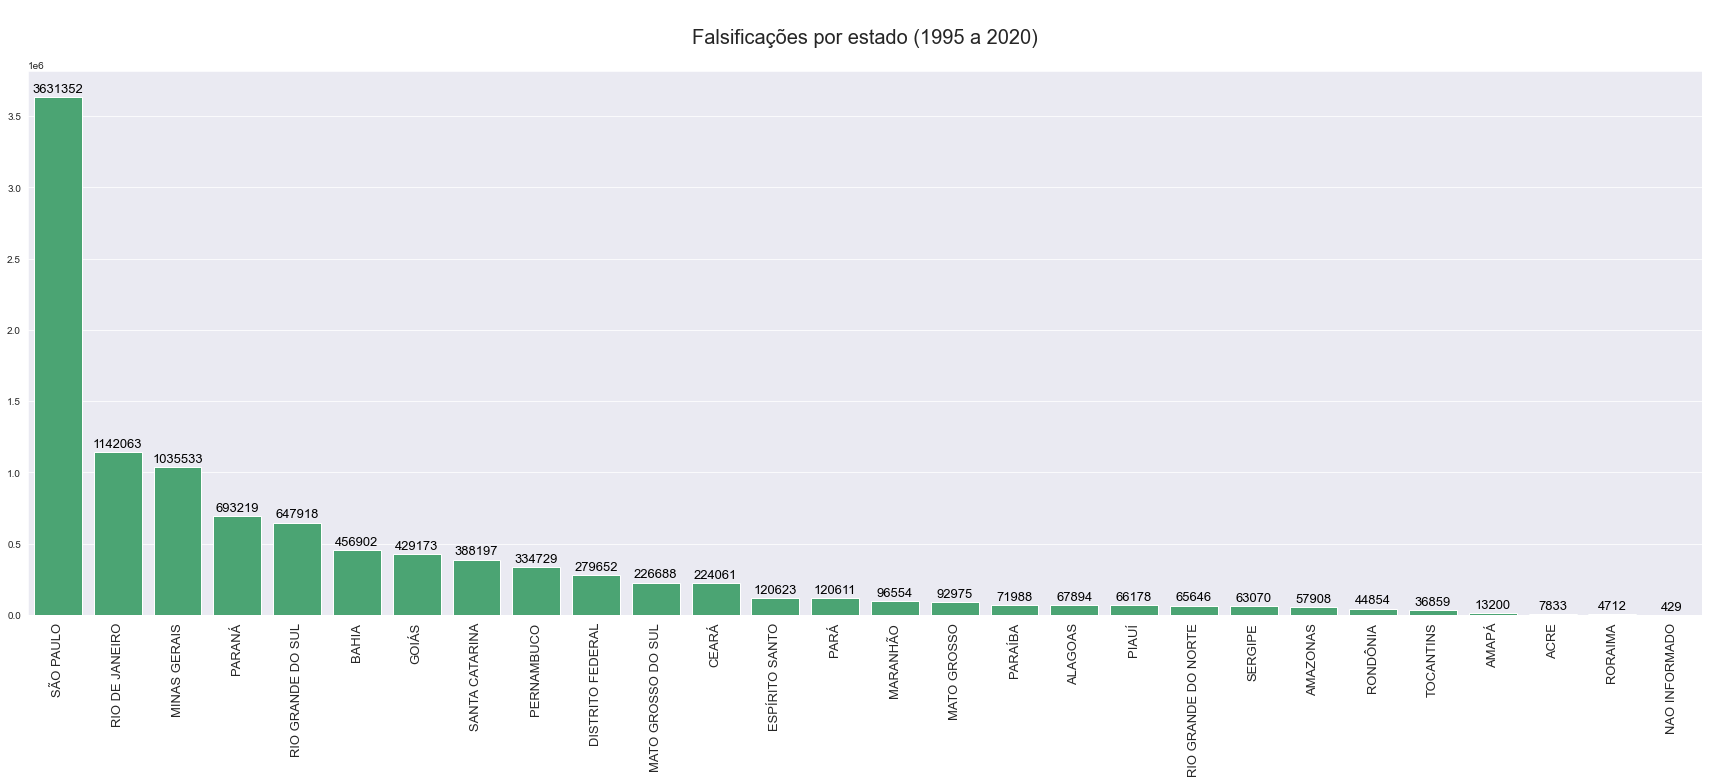

In [17]:
df_temp = df.groupby(['Estado'])['Quantidade'].sum()
df_estado_quantidade = pd.DataFrame(df_temp)
df_estado_quantidade['%'] = df_estado_quantidade['Quantidade'] / df_estado_quantidade['Quantidade'].sum() * 100

df_estado_quantidade = df_estado_quantidade.sort_values('Quantidade', ascending=False)

print(df_estado_quantidade) 

plt.figure(figsize=(30, 10))
plot = sns.barplot(x=df_estado_quantidade.index,
                   y=df_estado_quantidade['Quantidade'],
                   orient='v',
                   palette=['mediumseagreen'])
for i in plot.patches:
    plot.annotate(format(i.get_height(), '.0f'),
                  (i.get_x() + i.get_width() / 2, i.get_height()),
                  ha='center',
                  va='baseline',
                  fontsize=13,
                  color='black',
                  xytext=(0, 5),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90, size=13)
plt.title('\nFalsificações por estado (1995 a 2020)\n', fontsize=20)
plt.show(plot)


## 5. Qual a estimativa do total de falsificações por ano (2021 e 2022)?

In [18]:
df_ano_quantidade = df.groupby(['Ano'])['Quantidade'].sum()
df_ano_quantidade = pd.DataFrame(df_ano_quantidade)
df_ano_quantidade.index = pd.to_datetime(df_ano_quantidade.index, format='%Y')

df_ano_quantidade_full = df_full.groupby(['Ano'])['Quantidade'].sum()
df_ano_quantidade_full = pd.DataFrame(df_ano_quantidade_full)
df_ano_quantidade_full.index = pd.to_datetime(df_ano_quantidade_full.index, format='%Y')

df_ano_quantidade_full

,Quantidade
Ano,
1995-01-01,242
1996-01-01,16421
1997-01-01,624
1998-01-01,6874
1999-01-01,29162
2000-01-01,329111
2001-01-01,381709
2002-01-01,413883
2003-01-01,548887


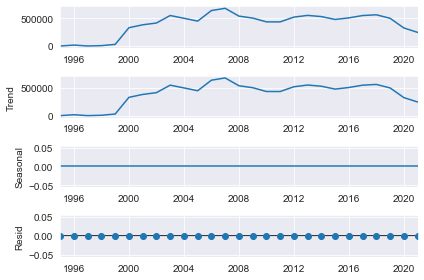

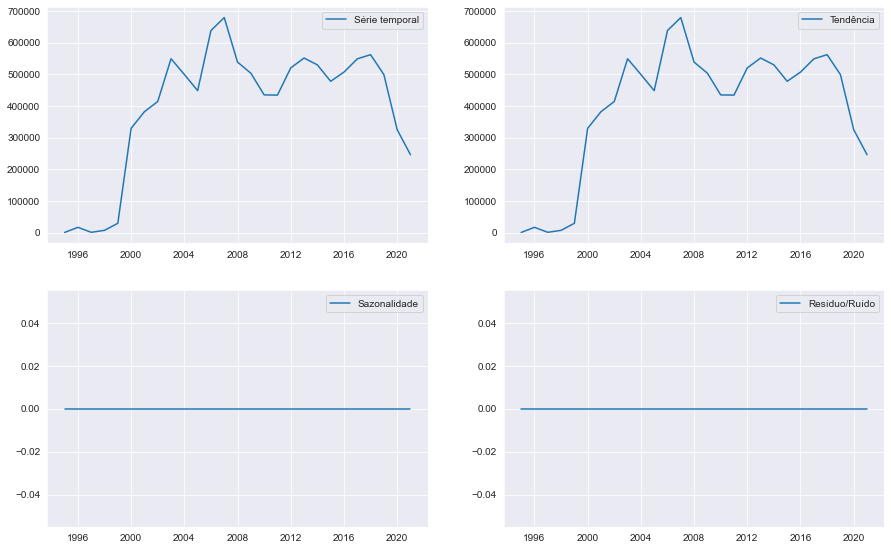

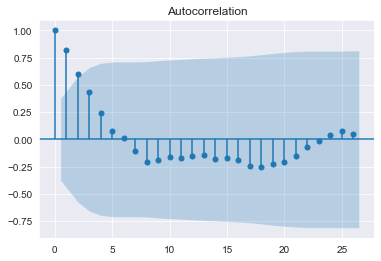

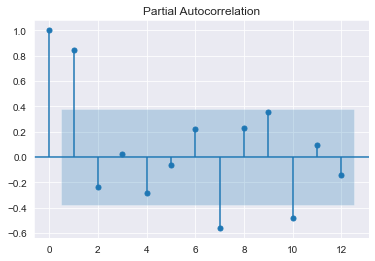

In [19]:
decomposicao = seasonal_decompose(df_ano_quantidade_full)

decomposicao.plot()

tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
residuo = decomposicao.resid

plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
plt.plot(df_ano_quantidade_full, label='Série temporal')
plt.legend(loc='best')

plt.subplot(4, 2, 2)
plt.plot(tendencia, label='Tendência')
plt.legend(loc='best')

plt.subplot(4, 2, 3)
plt.plot(sazonal, label='Sazonalidade')
plt.legend(loc='best')

plt.subplot(4, 2, 4)
plt.plot(residuo, label='Resíduo/Ruído')
plt.legend(loc='best')

plot = sm.graphics.tsa.plot_acf(df_ano_quantidade_full, lags=26)
plt.show(plot)

plot = sm.graphics.tsa.plot_pacf(df_ano_quantidade_full, lags=12)
plt.show(plot)
#sm.graphics.tsa.plot_predict(df_ano_quantidade_full, lags=26)


In [111]:
#modelo = ARIMA(df_ano_quantidade_full['Quantidade'], order=(0,2,1), freq=df_ano_quantidade.index.inferred_freq)
modelo = ARIMA(df_ano_quantidade_full['Quantidade'], order=(0,2,1), freq=df_ano_quantidade.index.inferred_freq)
modelo_treinado = modelo.fit()
print(modelo_treinado.summary())
print(modelo_treinado.forecast(steps=2)[0])

                             ARIMA Model Results                              
Dep. Variable:          D2.Quantidade   No. Observations:                   25
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -321.957
Method:                       css-mle   S.D. of innovations          88802.022
Date:                Mon, 28 Feb 2022   AIC                            649.913
Time:                        18:43:19   BIC                            653.570
Sample:                    01-01-1997   HQIC                           650.927
                         - 01-01-2021                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5003.6044   2322.074     -2.155      0.031   -9554.786    -452.422
ma.L1.D2.Quantidade    -1.0000      0.113     -8.866      0.000      -1.221      -0.779
                

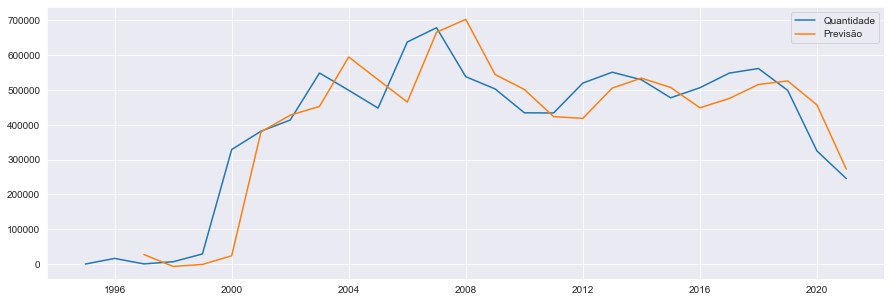

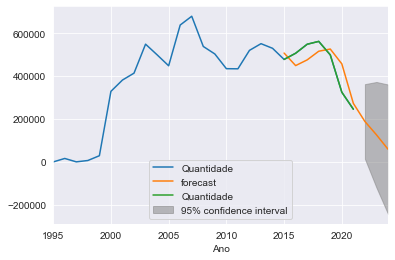

In [112]:
plt.figure(figsize=(15, 5))
plt.plot(df_ano_quantidade_full['Quantidade'])
plt.plot(modelo_treinado.predict(typ='levels'))
plt.legend(['Quantidade', 'Previsão'], loc='best')
plt.show(plot)

#plt.figure(figsize=(15, 5))
#plt.plot(df_ano_quantidade['Quantidade'])
#plt.plot(modelo_treinado.predict(typ='levels'))
#plt.legend(['Quantidade', 'Previsão'], loc='best')
#plt.show(plot)

eixo = df_ano_quantidade_full.plot()
plot = modelo_treinado.plot_predict('2015-01-01', '2024-01-01', ax=eixo, plot_insample=True)
plt.legend(loc='lower center')
plt.show(plot)

#eixo = df_ano_quantidade.plot()
#plot = modelo_treinado.plot_predict('2015-01-01', '2024-01-01', ax=eixo, plot_insample=True)
#plt.legend(loc='lower center')
#plt.show(plot)


In [66]:
#modelo_auto = auto_arima(df_ano_quantidade, m=1, seasonal=False, trace=False)
modelo_auto = auto_arima(df_ano_quantidade_full, 
start_p=0, start_q=0, 
max_p=9, max_q=9,
m=1, start_P=0, seasonal=False,
d=5,D=1,
trace=True, error_action='ignore', suppress_warnings=True,
stepwise=False)
modelo_auto



 ARIMA(0,5,0)(0,0,0)[0]             : AIC=651.128, Time=0.01 sec
 ARIMA(0,5,1)(0,0,0)[0]             : AIC=630.253, Time=0.03 sec
 ARIMA(0,5,2)(0,0,0)[0]             : AIC=618.214, Time=0.04 sec
 ARIMA(0,5,3)(0,0,0)[0]             : AIC=603.476, Time=0.04 sec
 ARIMA(0,5,4)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(0,5,5)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,5,0)(0,0,0)[0]             : AIC=642.663, Time=0.01 sec
 ARIMA(1,5,1)(0,0,0)[0]             : AIC=625.797, Time=0.03 sec
 ARIMA(1,5,2)(0,0,0)[0]             : AIC=613.984, Time=0.06 sec
 ARIMA(1,5,3)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,5,4)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,5,0)(0,0,0)[0]             : AIC=625.734, Time=0.02 sec
 ARIMA(2,5,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(2,5,2)(0,0,0)[0]             : AIC=597.710, Time=0.07 sec
 ARIMA(2,5,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(3,5,0)(0,0,0)[0]             : AIC=623.831

ARIMA(order=(2, 5, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

 ARIMA(2,5,2)(0,0,0)[0]          


<AxesSubplot:xlabel='Ano'>

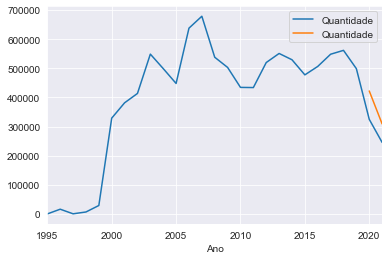

In [67]:
treino = df_ano_quantidade_full['1995-01-01':'2019-01-01']
teste = df_ano_quantidade_full['2020-01-01':]

print(modelo_auto.fit(treino))

previsao = modelo_auto.predict(n_periods=2)
previsao = pd.DataFrame(previsao, index=teste.index, columns=['Quantidade'])

pd.concat([df_ano_quantidade_full,previsao],axis=1).plot()

## 6. Qual a estimativa do total de falsificações por cédula e por ano (2021 e 2022)?

## 7. Qual a estimativa do total de falsificações por estado no período de 2021 e 2022?